In [ ]:
# import libraries to work with data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, skew
from IPython.display import display
from google.colab import drive
from sklearn.manifold import TSNE
from collections import Counter

drive.mount('/content/drive')
# load files with training data and testing data
data_train = pd.read_csv('/content/drive/MyDrive/source_files/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/source_files/test.csv')
# drop column 'Id' because it is unnecessary for prediction process
train_ID = data_train['Id']
test_ID = data_test['Id']  # column 'Id' in testing data will be used for submission file
data_train = data_train.drop(['Id'], axis=1)
data_test = data_test.drop(['Id'], axis=1)
# get ride of values where too many empty cells (more than 1000)
too_many_empty = [column for column in data_train.columns if data_train[column].isnull().sum() > 1000]
too_many_empty_test = [column for column in data_test.columns if data_test[column].isnull().sum() > 1000]
data_train = data_train.drop(too_many_empty, axis=1)
data_test = data_test.drop(too_many_empty, axis=1)
# check up columns to find empty cells
d_null = dict(data_train.isnull().sum())
d_null_test = dict(data_test.isnull().sum())
print({key: value for key, value in d_null.items() if d_null[key] != 0})  # {'LotFrontage': 259, 'MasVnrType': 8, 'MasVnrArea': 8, 'BsmtQual': 37, 'BsmtCond': 37, \
                                                                          # 'BsmtExposure': 38, 'BsmtFinType1': 37, 'BsmtFinType2': 38, 'Electrical': 1, 'FireplaceQu': 690, \
                                                                          # 'GarageType': 81, 'GarageYrBlt': 81, 'GarageFinish': 81, 'GarageQual': 81, 'GarageCond': 81}
print({key: value for key, value in d_null_test.items() if d_null_test[key] != 0})  # {'MSZoning': 4, 'LotFrontage': 227, 'Utilities': 2, 'Exterior1st': 1, 'Exterior2nd': 1, \
                                                                                    # 'MasVnrType': 16, 'MasVnrArea': 15, 'BsmtQual': 44, 'BsmtCond': 45, 'BsmtExposure': 44, \
                                                                                    # 'BsmtFinType1': 42, 'BsmtFinSF1': 1, 'BsmtFinType2': 42, 'BsmtFinSF2': 1, 'BsmtUnfSF': 1, \
                                                                                    # 'TotalBsmtSF': 1, 'BsmtFullBath': 2, 'BsmtHalfBath': 2, 'KitchenQual': 1, 'Functional': 2, \
                                                                                    # 'FireplaceQu': 730, 'GarageType': 76, 'GarageYrBlt': 78, 'GarageFinish': 78, 'GarageCars': 1, \
                                                                                    # 'GarageArea': 1, 'GarageQual': 78, 'GarageCond': 78, 'SaleType': 1}
# fill null cells
basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
# if these is no data about basement it means there is no basement. Take value 'NA' - no basement
for base in basement:
    data_train[base] = data_train[base].fillna('NA')
    data_test[base] = data_test[base].fillna('NA')
garage = ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']
# if these is no data about garage it means there is no garage. Take value 'NA' - no garage
for garag in garage:
    data_train[garag] = data_train[garag].fillna('NA')
    data_test[garag] = data_test[garag].fillna('NA')
# take data about built garage year as '0', that means like 'None'
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(0)
data_test['GarageYrBlt'] = data_test['GarageYrBlt'].fillna(0)
# no data about masonry veneer is no masonry veneer. Take empty cells value 'None'. Masonry veneer area is equal zero
data_train['MasVnrArea'] = data_train['MasVnrArea'].fillna(0)
data_test['MasVnrArea'] = data_test['MasVnrArea'].fillna(0)
data_train['MasVnrType'] = data_train['MasVnrType'].fillna('None')
data_test['MasVnrType'] = data_test['MasVnrType'].fillna('None')
# if these is no data about fireplace quality it means there is no fireplace. Take value 'NA' - no fireplace
data_train['FireplaceQu'] = data_train['FireplaceQu'].fillna('NA')
data_test['FireplaceQu'] = data_test['FireplaceQu'].fillna('NA')
# If it is unknown what type is used let's Electrical system be the most common (Standard Circuit - 1334 houses of 1459) 
data_train['Electrical'] = data_train['Electrical'].fillna(data_train['Electrical'].mode()[0])
# check up existence of columns with absent values
d_null = dict(data_train.isnull().sum())
print({key: value for key, value in d_null.items() if d_null[key] != 0}) # {'LotFrontage': 259}
d_null_test = dict(data_test.isnull().sum())
print({key: value for key, value in d_null_test.items() if d_null_test[key] != 0}) # {'MSZoning': 4, 'LotFrontage': 227, 'Utilities': 2, 'Exterior1st': 1, 'Exterior2nd': 1, \
                                                                                   # 'BsmtFinSF1': 1, 'BsmtFinSF2': 1, 'BsmtUnfSF': 1, 'TotalBsmtSF': 1, 'BsmtFullBath': 2, \
                                                                                   # 'BsmtHalfBath': 2, 'KitchenQual': 1, 'Functional': 2, 'GarageCars': 1, 'GarageArea': 1, \
                                                                                   # 'SaleType': 1}
# fill empty cells in testing dataframe. Numeric values is filled with zero, categoric - the most common values
data_test['MSZoning'] = data_test['MSZoning'].fillna(data_test['MSZoning'].mode()[0])  # Residential Low Density - 1114 houses of 1455
data_test['Utilities'] = data_test['Utilities'].fillna(data_test['Utilities'].mode()[0])  # All public Utilities - all 1457 houses not null
data_test['Exterior1st'] = data_test['Exterior1st'].fillna(data_test['Exterior1st'].mode()[0])  # Vinyl Siding - 510 houses. The next coverings are had 230 and 220 houses. \
                                                                                                # let alone null cell be filled with 'Vinyl Siding'
data_test['Exterior2nd'] = data_test['Exterior2nd'].fillna(data_test['Exterior2nd'].mode()[0])  # Vinyl Siding - 510 houses. The next coverings are had 233 and 199 houses.
data_test['BsmtFinSF1'] = data_test['BsmtFinSF1'].fillna(0)  # No basement is no area
data_test['BsmtFinSF2'] = data_test['BsmtFinSF2'].fillna(0)
data_test['BsmtUnfSF'] = data_test['BsmtUnfSF'].fillna(0)
data_test['TotalBsmtSF'] = data_test['TotalBsmtSF'].fillna(0)
data_test['BsmtFullBath'] = data_test['BsmtFullBath'].fillna(0)  # and no bath
data_test['BsmtHalfBath'] = data_test['BsmtHalfBath'].fillna(0)
data_test['KitchenQual'] = data_test['KitchenQual'].fillna(data_test['KitchenQual'].mode()[0])  # Let kitchen be Typical/Average (757 houses of 1458)
data_test['Functional'] = data_test['Functional'].fillna(data_test['Functional'].mode()[0])  # Let Home functionality be Typical (1357 houses of 1457)
data_test['GarageCars'] = data_test['GarageCars'].fillna(0)  # no garage - no area
data_test['GarageArea'] = data_test['GarageArea'].fillna(0)
data_test['SaleType'] = data_test['SaleType'].fillna(data_test['SaleType'].mode()[0])  # Warranty Deed - Conventional - 1258 houses of 1458
# group streets by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data_train['LotFrontage'] = data_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
data_test['LotFrontage'] = data_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# apply string type for all values in MSSubClass
data_train['MSSubClass'] = data_train['MSSubClass'].apply(str)
data_test['MSSubClass'] = data_test['MSSubClass'].apply(str)
# Year and month sold are transformed into categorical features.
data_train['YrSold'] = data_train['YrSold'].astype(str)
data_train['MoSold'] = data_train['MoSold'].astype(str)
data_test['YrSold'] = data_test['YrSold'].astype(str)
data_test['MoSold'] = data_test['MoSold'].astype(str)
# make sure that all values in dataframes are not null
d_null = dict(data_train.isnull().sum())
print({key: value for key, value in d_null.items() if d_null[key] != 0})  # {}
d_null_test = dict(data_test.isnull().sum())
print({key: value for key, value in d_null_test.items() if d_null_test[key] != 0})  # {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'LotFrontage': 259, 'MasVnrType': 8, 'MasVnrArea': 8, 'BsmtQual': 37, 'BsmtCond': 37, 'BsmtExposure': 38, 'BsmtFinType1': 37, 'BsmtFinType2': 38, 'Electrical': 1, 'FireplaceQu': 690, 'GarageType': 81, 'GarageYrBlt': 81, 'GarageFinish': 81, 'GarageQual': 81, 'GarageCond': 81}
{'MSZoning': 4, 'LotFrontage': 227, 'Utilities': 2, 'Exterior1st': 1, 'Exterior2nd': 1, 'MasVnrType': 16, 'MasVnrArea': 15, 'BsmtQual': 44, 'BsmtCond': 45, 'BsmtExposure': 44, 'BsmtFinType1': 42, 'BsmtFinSF1': 1, 'BsmtFinType2': 42, 'BsmtFinSF2': 1, 'BsmtUnfSF': 1, 'TotalBsmtSF': 1, 'BsmtFullBath': 2, 'BsmtHalfBath': 2, 'KitchenQual': 1, 'Functional': 2, 'FireplaceQu': 730, 'GarageType': 76, 'GarageYrBlt': 78, 'GarageFinish': 78, 'GarageCars': 1, 'GarageArea': 1, 'GarageQual': 78, 'GarageCond': 78, 'SaleType': 1}
{'LotFrontage': 259}
{'MSZoning': 4, 'LotFrontage': 227, 'Utilities': 2, 'E

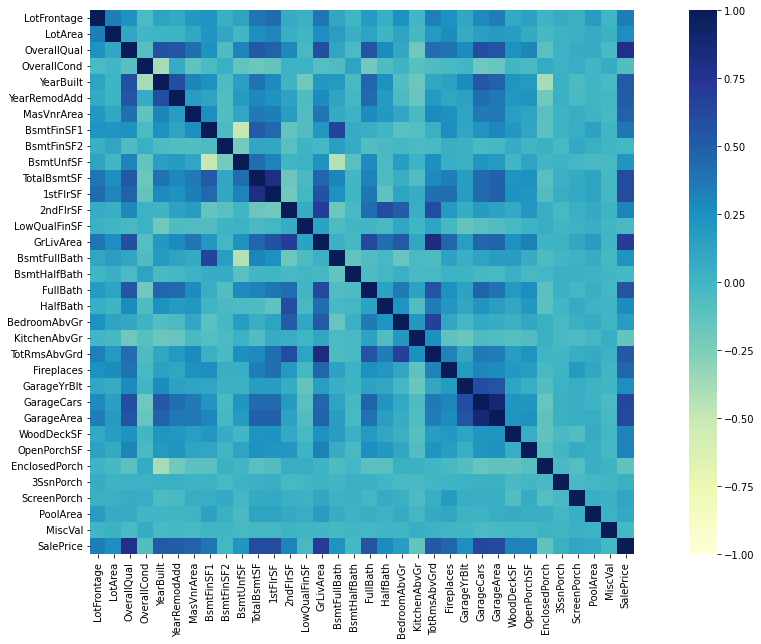

In [ ]:
# make heatmap of correlations between columns of the dataframe (work with traning data)
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data_train.corr(), vmin=-1, vmax=1, square=True, cmap='YlGnBu')

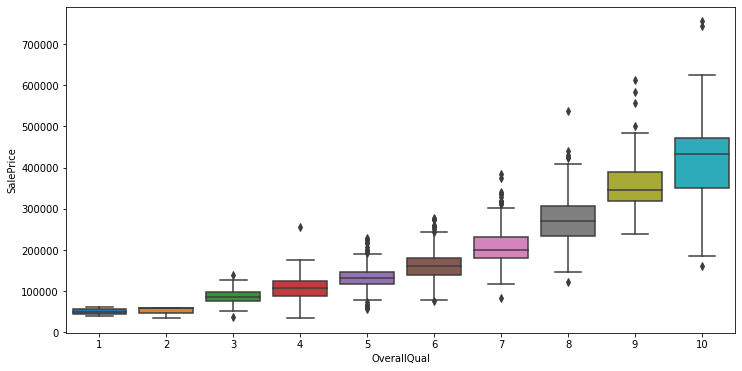

In [ ]:
# create boxplot to image price diapason for each quality estimation
sns.boxplot(y='SalePrice', x='OverallQual', data=data_train)  # sale price is direct proportionality of overall quality

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


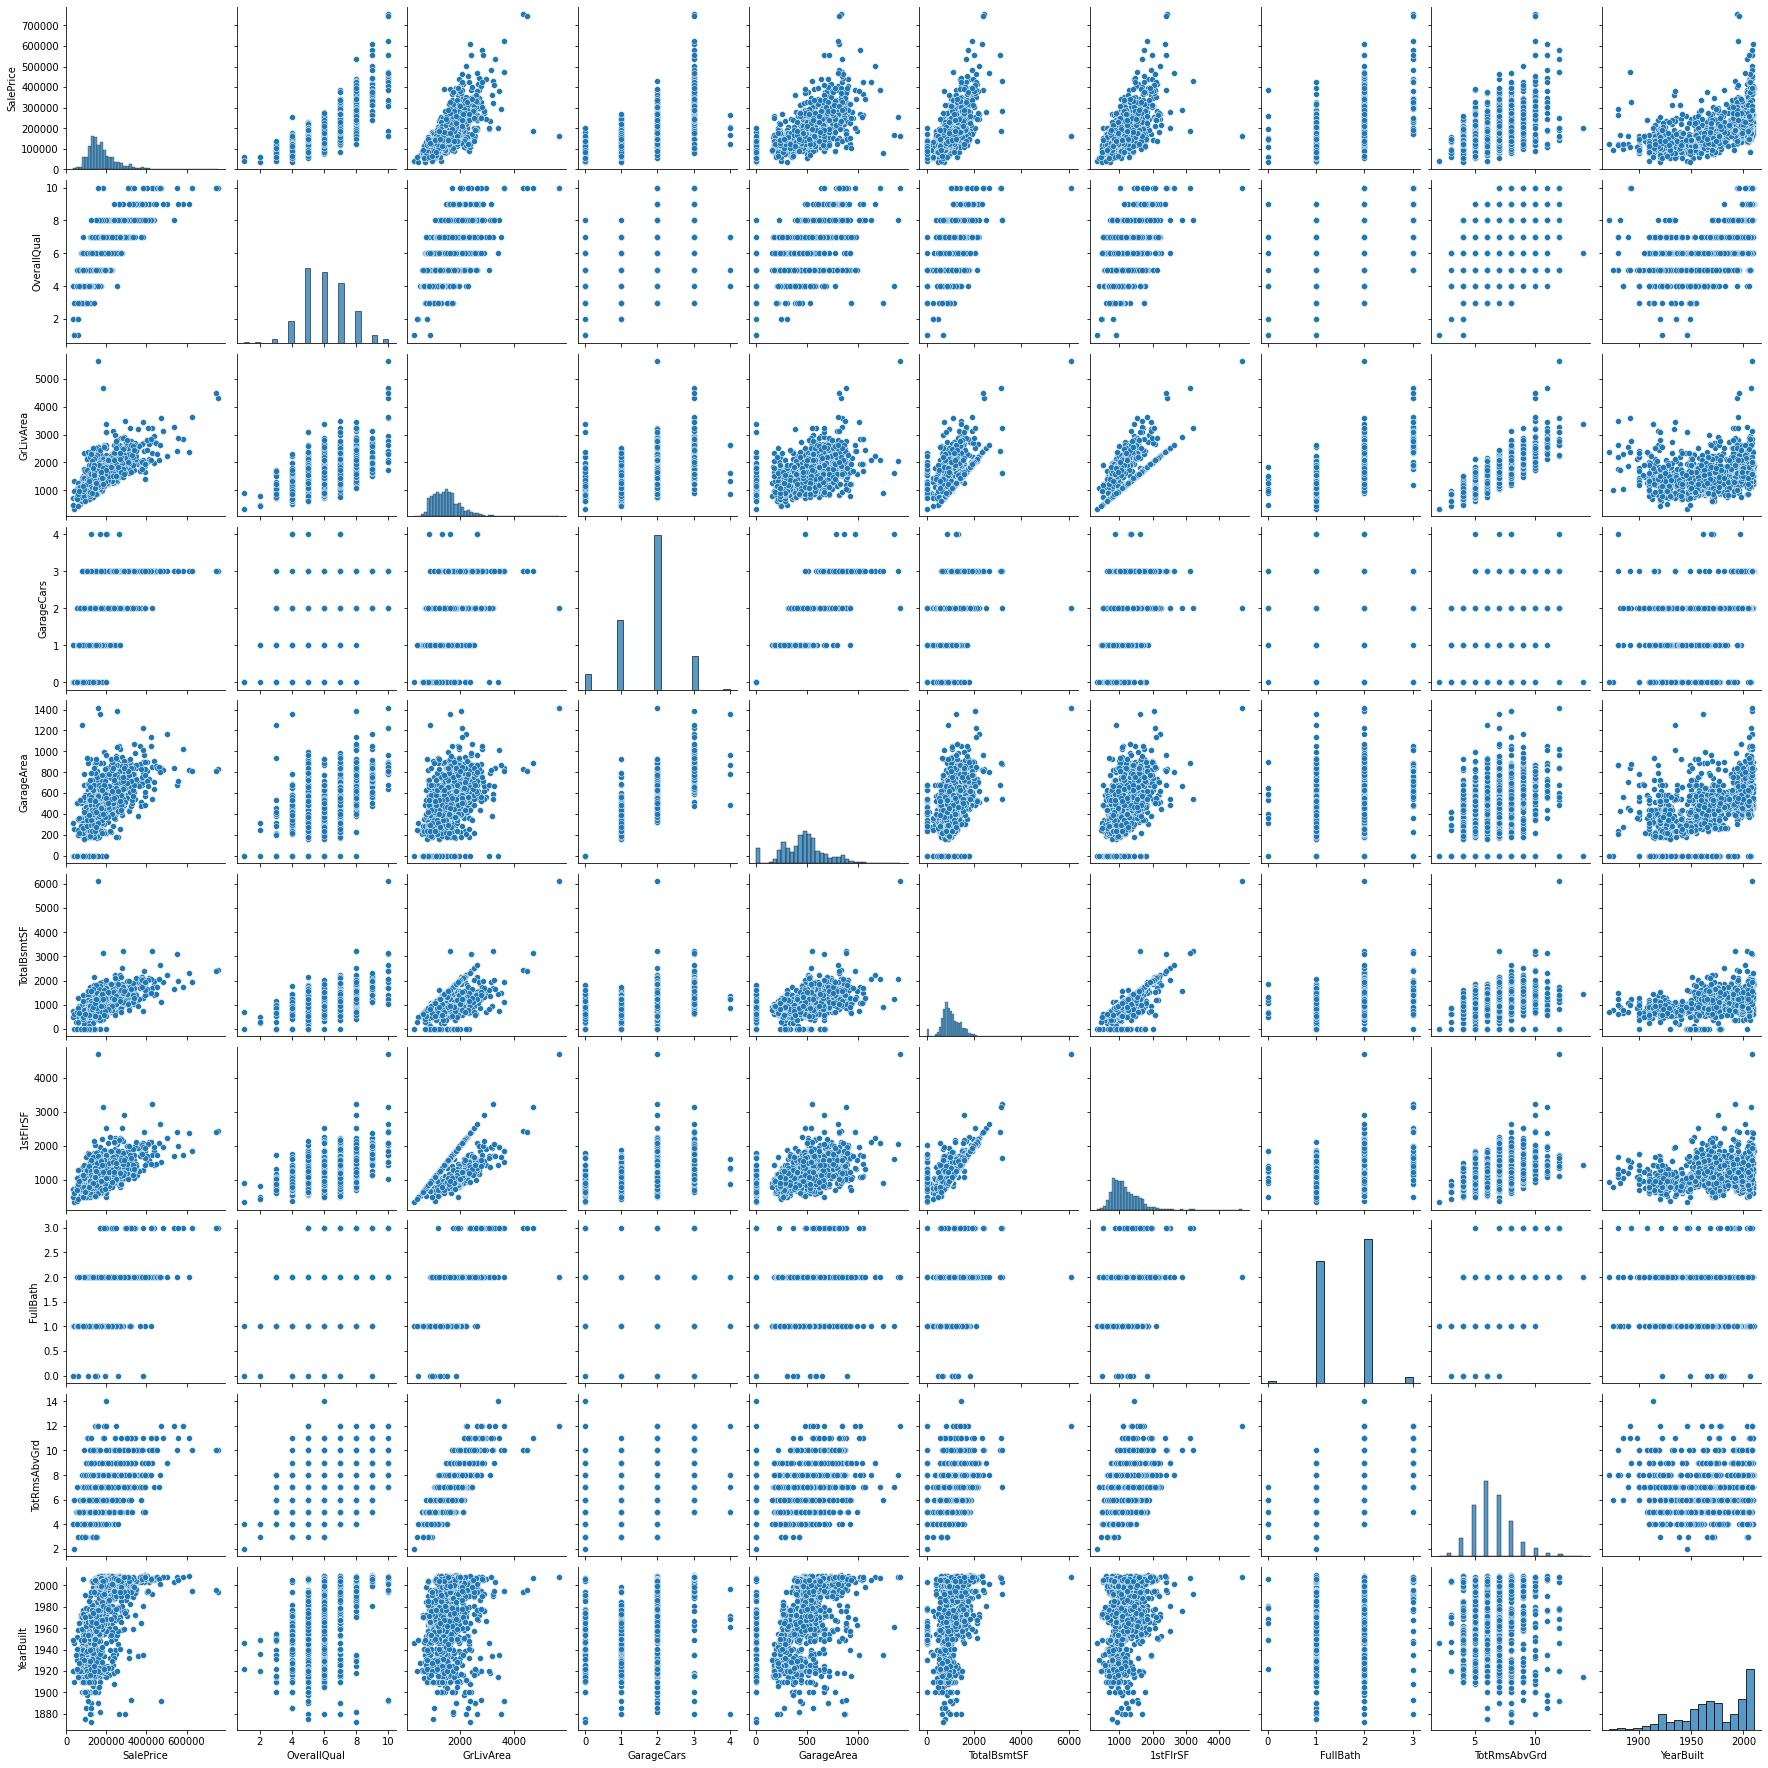

In [ ]:
# make pairplots of the most correlated columns with sale price between each other
the_strongest_corr = data_train.corr()['SalePrice'].sort_values(ascending=False)[:10]
sns.pairplot(data_train[dict(the_strongest_corr).keys()], size=2.5)
plt.show()

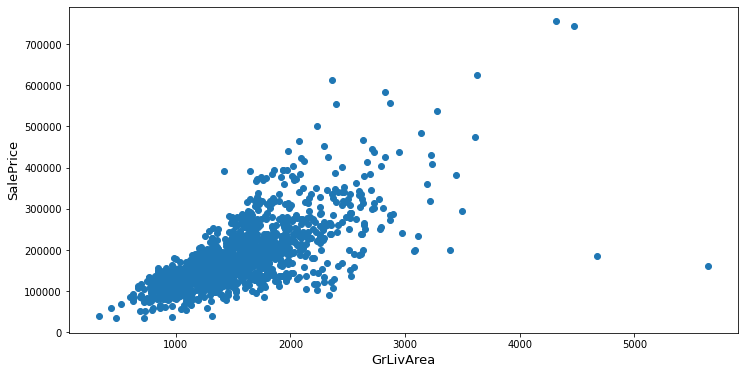

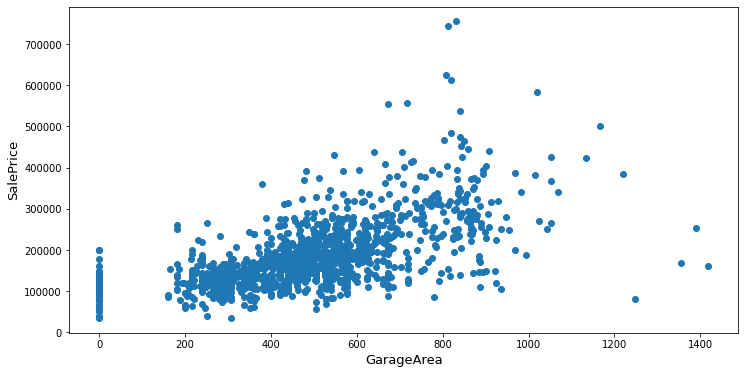

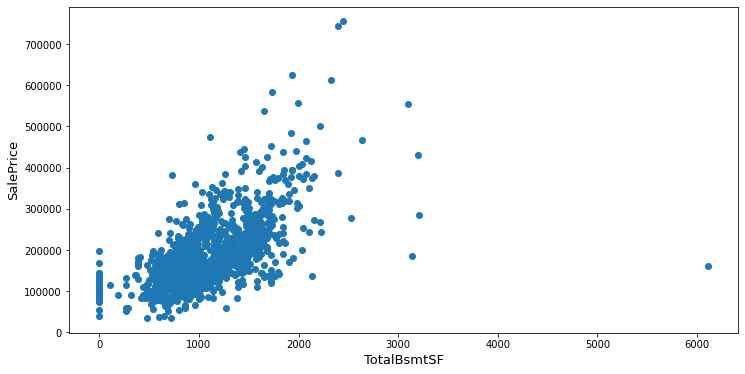

In [ ]:
# price is directly depended on all parametres on these plots. But some of these plots have values which don't match overall plot's tendency
fig, ax = plt.subplots()
ax.scatter(x = data_train['GrLivArea'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
fig, ax = plt.subplots()
ax.scatter(x = data_train['GarageArea'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()
fig, ax = plt.subplots()
ax.scatter(x = data_train['TotalBsmtSF'], y = data_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

In [ ]:
# on the first plot house price increases when living area above grade grows up. But two houses with area more than 4000 square feet have less price and skew from common group
data_train = data_train.drop(data_train[(data_train['GrLivArea'] > 4000) & (data_train['SalePrice'] < 300000)].index)  # let's delete these outliers
# on the second plot few prices are less than others but they aren't deviated from common group
# on the third plot house price increases exponentially. More than 3500 square feet there is one house (near 6100) with price less than ones with area 3000. This house skews from common group
data_train = data_train.drop(data_train[(data_train['TotalBsmtSF'] > 6000) & (data_train['SalePrice'] < 200000)].index)  # let's delete this outlier

In [ ]:
data = data_train.copy()
# divide parametres into numeric (digit) and categoric (type or mark)
categoric = [feature for feature in data.columns if data[feature].dtype == 'object']  # categoric columns have type 'object'
number = [len(data[features].unique()) for features in categoric]  # another ones have type 'int' or 'float'
data_tuples = list(zip(categoric, number))
categorical_data = pd.DataFrame(data_tuples, columns=['Features', 'Number of distinct values'])  # calculate how many values has each categoric variable
categorical_data

,Features,Number of distinct values
0,MSSubClass,15
1,MSZoning,5
2,Street,2
3,LotShape,4
4,LandContour,4
5,Utilities,2
6,LotConfig,5
7,LandSlope,3
8,Neighborhood,25
9,Condition1,9


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


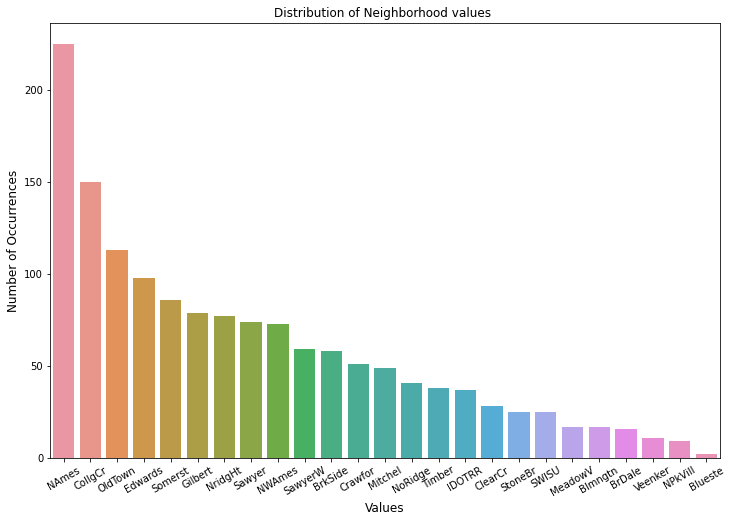

In [ ]:
# for variable 'Neighborhood' let's distribute values by count of houses
plt.figure(figsize=(12,8))
n_count = data['Neighborhood'].value_counts()
plot=sns.barplot(n_count.index, n_count.values)
plt.setp(plot.get_xticklabels(), rotation=30, fontsize=10)
plt.title('Distribution of Neighborhood values ')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Values', fontsize=12)
plt.show()

In [ ]:
# with module 'LabelEncoder' take for categoric features digit values
from sklearn.preprocessing import LabelEncoder
testing_data = data_test.copy()
for c in categoric:
    label_encoder = LabelEncoder() 
    label_encoder.fit(list(data[c].values)) 
    data[c] = label_encoder.transform(list(data[c].values))
for c in categoric:
    label_test_encoder = LabelEncoder()
    label_test_encoder.fit(list(testing_data[c].values))
    testing_data[c] = label_test_encoder.transform(list(testing_data[c].values))
training_data = data.copy()
testing_1_data = testing_data.copy()

SalePrice       1.000000
OverallQual     0.795774
GrLivArea       0.734968
TotalBsmtSF     0.651153
GarageCars      0.641047
1stFlrSF        0.631530
GarageArea      0.629217
FullBath        0.562165
TotRmsAbvGrd    0.537769
YearBuilt       0.523608
YearRemodAdd    0.507717
MasVnrArea      0.477810
Fireplaces      0.469862
BsmtFinSF1      0.409384
Name: SalePrice, dtype: float64


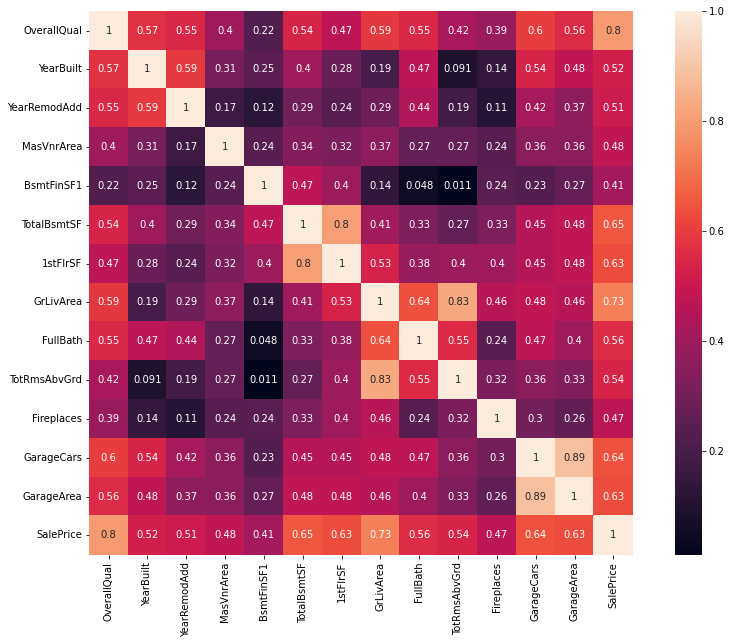

In [ ]:
x_corr = []  # this list has columns which are correlated with column 'SalePrice'
corr_indexes = dict(training_data.corr().SalePrice)
# let coefficients be more than 0.4 (strong link)
for corr_index in corr_indexes.keys():
    if corr_indexes[corr_index] >= 0.4:
        x_corr.append(corr_index)
corr_df = training_data[x_corr].corr()  # dataframe with correlation indexes
print(corr_df['SalePrice'].sort_values(ascending=False))
fig = plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, square=True)

Skewness: 1.881296
Kurtosis: 6.523067



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


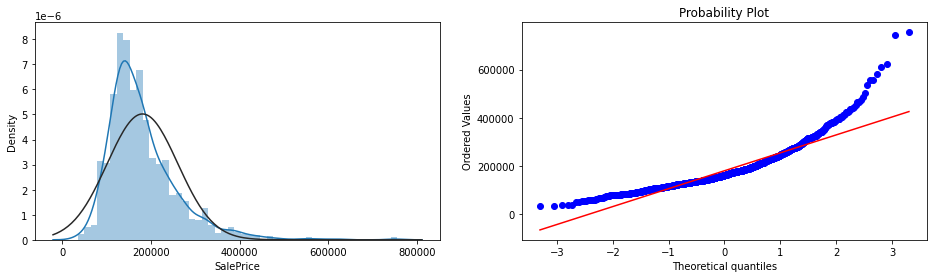

In [ ]:
print("Skewness: %f" % training_data['SalePrice'].skew())  # find a measure of asymmetry of a distribution
print("Kurtosis: %f" % training_data['SalePrice'].kurt())  # find a shape of a distribution
print()
# create distplot of distribution of saleprices and image distribution curve and normal distribution curve
# create probability plot
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.distplot(training_data['SalePrice'] , fit=norm, ax=ax[0])
# Get also the QQ-plot
res = stats.probplot(training_data['SalePrice'], plot=ax[1])
plt.show()
# we have exponential distribution of prices

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f86102a10>,
      dtype=object)

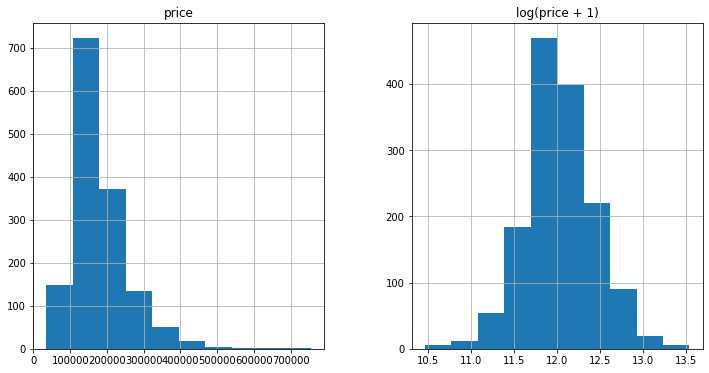

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12.0, 6.0)
# compare distribution histograms with source prices and logarithmic prices (log(price): exp ** log(price) = price)
prices = pd.DataFrame({"price":training_data["SalePrice"], "log(price + 1)":np.log1p(training_data["SalePrice"])})
prices.hist()

Skewness: 0.121580
Kurtosis: 0.804751



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


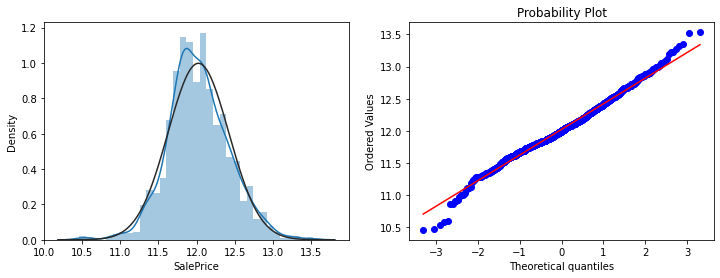

In [ ]:
training_data["SalePrice"] = np.log1p(training_data["SalePrice"])
print("Skewness: %f" % training_data['SalePrice'].skew())
print("Kurtosis: %f" % training_data['SalePrice'].kurt())
print()
# logarithmic prices have normal distribution and direct linear dependence
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.distplot(training_data['SalePrice'] , fit=norm, ax=ax[0])
# Get also the QQ-plot
res = stats.probplot(training_data['SalePrice'],plot=ax[1])
plt.show()


In [ ]:
# Adding total sqfootage feature is the summ of basement area, the first floor area and the second floor area
# 'TotalBsmtSF' and '1stFlrSF' features have strong correlation (0.8)
training_data['TotalSF'] = training_data['TotalBsmtSF'] + training_data['1stFlrSF'] + training_data['2ndFlrSF']
testing_1_data['TotalSF'] = testing_1_data['TotalBsmtSF'] + testing_1_data['1stFlrSF'] + testing_1_data['2ndFlrSF']
# Adding total above ground feature: the sum of the first floor area and the second floor area
training_data['TotalAboveGroundSF'] = training_data['1stFlrSF'] + training_data['2ndFlrSF']
testing_1_data['TotalAboveGroundSF'] = testing_1_data['1stFlrSF'] + testing_1_data['2ndFlrSF']
# All bathrooms - the sum of full bathrooms and half bathrooms above grade 
training_data['AllBath'] = training_data['FullBath'] + training_data['HalfBath']
training_data['BsmtAllBath'] = training_data['BsmtFullBath'] + training_data['BsmtHalfBath']  # and in the basement
training_data['FullAllBath'] = training_data['AllBath'] + training_data['BsmtAllBath']  # total in a house
testing_1_data['AllBath'] = testing_1_data['FullBath'] + testing_1_data['HalfBath']
testing_1_data['BsmtAllBath'] = testing_1_data['BsmtFullBath'] + testing_1_data['BsmtHalfBath']
testing_1_data['FullAllBath'] = testing_1_data['AllBath'] + testing_1_data['BsmtAllBath']
# Average Bedroom in a house (above ground area for one person (bedroom))
eps = 0.125  # coefficient which means error term in linear regression. If count of bedrooms is zero, average will be infinite
training_data['AverageBedroomSF'] = training_data['TotalAboveGroundSF'] / (training_data['BedroomAbvGr'] + eps)
testing_1_data['AverageBedroomSF'] = testing_1_data['TotalAboveGroundSF'] / (testing_1_data['BedroomAbvGr'] + eps)
# Bedroom / Bathroom ratio - how many people can use one bathroom
training_data['BedroomBathroomRatio'] = training_data['BedroomAbvGr'] / (training_data['AllBath'] + eps)
testing_1_data['BedroomBathroomRatio'] = testing_1_data['BedroomAbvGr'] / (testing_1_data['AllBath'] + eps)

def build_agg_values(df, group_variable, feature, operation):
    """
    group data in the dataframe by some criteria and make calculation in such group. Given values merge to dataframe and distribute by group
    param df: sourse dataframe
    param group_variable: criterion for grouping (for example, vales of some column)
    param feature: column is needed to be aggregated
    param operation: aggregating function for groups
    return: new dataframe with column witn aggregation values
    """
    aver_group = df.groupby(group_variable)[feature].agg([operation]).rename({operation: f'{feature}_{group_variable}_{operation}'}, axis=1)  # give dataframe with calculations
    new_dataframe = pd.merge(df, aver_group, on=group_variable, how='left')  # and merge the column to source dataframe
    return new_dataframe

n = len(training_data)  # calculate count of rows in training data
all_data = pd.concat((training_data, testing_1_data))  # and connect training and testing dataframes (training dataframe is joined after training)
# let's group values of feature 'TotalAboveGroundSF' by count of bedrooms and find average mean for each group
all_data = build_agg_values(all_data, 'BedroomAbvGr', 'TotalAboveGroundSF', 'mean')
# group values of feature 'TotalAboveGroundSF' by count of bathrooms (average)
all_data = build_agg_values(all_data, 'AllBath', 'TotalAboveGroundSF', 'mean')
# group values of feature 'AllBath' by locations (each district has definite water supply) (average)
all_data = build_agg_values(all_data, 'Neighborhood', 'AllBath', 'mean')
# group values of feature '1stFlrSF' by locations (how big houses are built in one or the other district) (average)
all_data = build_agg_values(all_data, 'Neighborhood', '1stFlrSF', 'mean')
# group values of feature 'BedroomAbvGr' by locations (what family or person can live in one or the other district) (average)
all_data = build_agg_values(all_data, 'Neighborhood', 'BedroomAbvGr', 'mean')

In [ ]:
# log transform of the skewed numerical features to lessen impact of outliers
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index  # save the dataframe with only numerical features
# drop all null values from dataframe for calculation skewness (there aren't null values)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False) #compute skewness
print(skewed_feats.head(10))
print(skewed_feats.index)

Utilities           53.981481
MiscVal             21.939672
AverageBedroomSF    17.688751
PoolArea            17.688664
LotArea             13.109495
Condition2          12.340989
LowQualFinSF        12.084539
3SsnPorch           11.372080
RoofMatl            10.764459
LandSlope            4.973254
dtype: float64
Index(['Utilities', 'MiscVal', 'AverageBedroomSF', 'PoolArea', 'LotArea',
       'Condition2', 'LowQualFinSF', '3SsnPorch', 'RoofMatl', 'LandSlope',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'Condition1', 'MasVnrArea', 'OpenPorchSF', 'BldgType',
       'WoodDeckSF', 'RoofStyle', '1stFlrSF',
       'TotalAboveGroundSF_BedroomAbvGr_mean', 'Heating', 'LotFrontage',
       'BedroomBathroomRatio', 'GrLivArea', 'TotalAboveGroundSF', 'TotalSF',
       'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'TotalAboveGroundSF_AllBath_mean',
       'GarageType', 'BsmtFullBath', 'OverallCon

In [ ]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# skewness with an absolute value > 0.75 is considered moderately skewed
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_features = skewed_feats.index
# function boxcox1p computes the Box-Cox transformation of 1 + x:
# y = ((1+x)**lambda - 1) / lambda, if lambda != 0;
# log(1+x), if lambda == 0
lambda_value = 0.15
# transform features with the function
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lambda_value)

In [ ]:
# return training and testing dataframes from whole one
# formulate X_train, y_train and X_test dataframes for predictions
X_train = all_data[:n]
X_test = all_data[n:]
y_train = X_train.SalePrice
X_train = X_train.drop(['SalePrice'], axis=1)
X_test = X_test.drop(['SalePrice'], axis=1)

In [ ]:
# from libraries import functions describing models
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# prepare possible models for data
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
elastic_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
kernel_model = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
grad_boost_regr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                            min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571, 
                             subsample=0.5213, silent=1, random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, 
                              bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9,
                              bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
def find_model(model, X_train=X_train, y_train=y_train):
    """
    based on training data by cross-validation prepared model calculate list of square errors
    param model: prepared model for cross-validation
    param X_train: source parametres of data
    param y_train: source sale price dataframe
    return: list of average squared devitations
    """
    cv = KFold(10, shuffle=True, random_state=42)  # divide dataframe into 10 parts and each of them is used as testing
    square_error = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")  # use cross-validation
    average_square_error = np.sqrt(-square_error)  # calculate standard deviations
    return average_square_error

# find out score standard deviation and average squared error for each model 
print(find_model(lasso_model).mean(), find_model(lasso_model).std())
print(find_model(elastic_model).mean(), find_model(elastic_model).std())
print(find_model(kernel_model).mean(), find_model(kernel_model).std())
print(find_model(grad_boost_regr).mean(), find_model(grad_boost_regr).std())
print(find_model(model_xgb).mean(), find_model(model_xgb).std())
print(find_model(model_lgb).mean(), find_model(model_lgb).std())

0.11618105341761367 0.013376412477875636
0.11616959851964052 0.013351653059562752
0.18330398149369356 0.01849089361484413
0.11394777528081246 0.016163801023149925
0.1132876523996438 0.015834761355768993
0.11493016448612822 0.01566041057278099


In [ ]:
# the lowest values of average square error - XGB Regression model (0.11329) and Gradient Boosting Regression model (0.11395)
# a lit more mean have LGBM Regression (0.11493), Elastic (0.11617) and Lasso (0.11618) models
# kernel model have significantly more mean (0.18330) 
# So all models beside kernel model let's be united by class with inheritance from BaseEstimator, TransformerMixin and RegressorMixin
class Average_Predict(BaseEstimator, TransformerMixin, RegressorMixin):
    """
    class for models estimation, data transformation and regression estimation.
    
    Attribute models(list): list of prepared models for estimation
    attribute X(object): training dataframe with parametres for prediction
    attribute y(object): training dataframe with sale prices for prediction
    
    Methods:
    fit(X, y): fit model with training data
    predict: predict sale prices based on testing data 
    """
    def __init__(self, models):
        """
        Take attributes for object Average_Predict
        param models: list of models are needed to be united in the whole model for prediction
        """
        self.models = models
    
    def fit(self, X, y):
        """
        fitting data in the whole model
        param X: training dataframe with parametres
        param y: training dataframe with sale prices
        return: fitting model
        """
        self.models_ = [clone(x) for x in self.models]  # duplicate source models for following prediction
        for model in self.models_:
            model.fit(X, y)
        return self

    def predict(self, X):
        """
        predict sale prices based on testing data
        param X: testing data for prediction
        return: average mean of prices for each house
        """
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

average_models = Average_Predict(models=(lasso_model, elastic_model, grad_boost_regr, model_xgb, model_lgb))
find_model(average_models).mean()  # standart deviation with united model

0.10927215551810728

In [ ]:
# average square error with united model is 0.10927, that is less than all of models to be united
def sq_er(y, y_pred):
    """
    calculate average squared errors predicted price from source
    param y: house price in according to task
    param y_pred: house price is given by prediction where X_train dataframe is taken as testing
    return: standart deviation of prediction from the task
    """
    return np.sqrt(mean_squared_error(y, y_pred))

# fit united model by training data
average_models.fit(X_train, y_train)
# calculate task house prices by prediction and standart deviation
aver_train_pred = average_models.predict(X_train)
print(sq_er(y_train, aver_train_pred))
# predict house sale prices for testing data
aver_pred = average_models.predict(X_test)
# previously we use logarithmic method (prices are logarithmed by logp1: y = log(x + 1))
# so we use exponential (x = exp ** y - 1): np.expm1)
aver_pred = np.expm1(aver_pred)
# the same way process prediction with kernel model
kernel_model.fit(X_train, y_train)
kernel_train_pred = kernel_model.predict(X_train)
print(sq_er(y_train, kernel_train_pred))
kernel_pred = kernel_model.predict(X_test)
kernel_pred = np.expm1(kernel_pred)

0.07661357223187
0.04918324676277442


In [ ]:
# 5 model of 6 create united model. It is 83 % of all models. Distribute prediction values between models for combination
# 83% for united model, 17% for kernel model
final_predictions = (0.83 * aver_pred + 0.17 * kernel_pred).round(0)

In [ ]:
# let's make dataframe with predicted prices and matched testing indexes
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_predictions})
submission.to_csv('my_predictions.csv', index=False)